## Imports

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
import os
from os.path import join as pjoin
import sys
import time
import typing as t
from pprint import pprint
import itertools
from inspect import signature
from tqdm.notebook import tqdm
import pickle
import json
import joblib
import collections

import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, clear_output

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [ ]:
# Подключение данных гугл диска
import os
from google.colab import drive, userdata
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN_CIO')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import logging
import time

def create_logger() -> logging.Logger:
  root_logger = logging.getLogger()
  for handler in root_logger.handlers[:]:
      root_logger.removeHandler(handler)
  root_logger.setLevel(logging.WARNING) # Optionally set root level high

  # 2. Get your specific logger and clear any handlers it might already have
  logger = logging.getLogger(__name__)
  for handler in logger.handlers[:]:
      logger.removeHandler(handler)
  # --------------------------------------------------
  # 1. Create a Handler
  handler = logging.StreamHandler()
  # 2. Create a Formatter
  formatter = logging.Formatter(
      '%(asctime)s %(levelname)s: %(message)s',
      # Note: Use a precise datefmt string for consistency
      datefmt='%Y-%m-%d %H:%M:%S'
  )
  # 3. Apply the Formatter
  handler.setFormatter(formatter)
  # 4. Attach the configured Handler
  logger.addHandler(handler)
  # 5. Prevent propagation (still good practice)
  logger.propagate = False
  logger.setLevel(logging.INFO)
  return logger

logger = create_logger()

logger.info('Hey there!')
time.sleep(2)
logger.info('Hello (2 seconds after)')

2025-10-16 11:54:30 INFO: Hey there!
2025-10-16 11:54:32 INFO: Hello (2 seconds after)


---

following this post: https://pub.towardsai.net/no-libraries-no-shortcuts-llm-from-scratch-with-pytorch-664c557997ee

## Defining the model

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

class SelfAttention(nn.Module):
  def __init__(
    self,
    input_emb_dim: int,
    attention_dim: int,
    bias: bool = False,
    dropout_prob: float = 0.1,
  ):
    super().__init__()
    self.Wq = nn.Linear(
        in_features=input_emb_dim,
        out_features=attention_dim,
        bias=bias
    )
    self.Wk = nn.Linear(
        in_features=input_emb_dim,
        out_features=attention_dim,
        bias=bias
    )
    self.Wv = nn.Linear(
        in_features=input_emb_dim,
        out_features=attention_dim,
        bias=bias
    )
    self.dropout = nn.Dropout(p=dropout_prob)

    self._attention_dim = attention_dim

  def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
    BatchSize, SeqLen, EmbDim = x.shape

    q = self.Wq(x) # (BatchSize, SeqLen, attention_dim)
    k = self.Wk(x) # (BatchSize, SeqLen, attention_dim)
    v = self.Wv(x) # (BatchSize, SeqLen, attention_dim)

    dim_k = self._attention_dim
    attention_scores = (
      (
        q  # (BatchSize, SeqLen, attention_dim)
        @ k.transpose(-2, -1) # (BatchSize, attention_dim, SeqLen)
      ) # (BatchSize, SeqLen, SeqLen)
    ) / (dim_k ** 0.5)

    causal_mask = torch.triu(
        input=torch.ones((SeqLen, SeqLen), device=x.device),
        diagonal=1
    ).bool()

    attention_scores = attention_scores.masked_fill(causal_mask, float('-1e10')) # (BatchSize, SeqLen, SeqLen)
    attention_weights = attention_scores.softmax(dim=-1) # (BatchSize, SeqLen, SeqLen)
    result = self.dropout(attention_weights) @ v # (BatchSize, SeqLen, SeqLen) x (BatchSize, SeqLen, attention_dim)
    return result # (BatchSize, SeqLen, attention_dim)


class MultiheadAttention(nn.Module):
  def __init__(
    self,
    input_emb_dim: int,
    num_heads: int,
    attention_dim: int,
    bias: bool = False,
    dropout_prob: float = 0.1,
  ):
    super().__init__()

    assert attention_dim % num_heads == 0, (
        f"{attention_dim=} should be multiple of {num_heads=}"
    )

    self.one_head_attention_dim = attention_dim // num_heads
    self.heads = nn.ModuleList([
        SelfAttention(
          input_emb_dim=input_emb_dim,
          attention_dim=self.one_head_attention_dim,
          bias=bias,
          dropout_prob=dropout_prob,
        )
        for _ in range(num_heads)
    ])

  def forward(
    self,
    x: torch.FloatTensor
  ) -> torch.FloatTensor:
    return torch.cat([
        head(x) # (BatchSize, SeqLen, AttentionEmbDim // num_heads)
        for head in self.heads
    ], dim=2) # # (BatchSize, SeqLen, AttentionEmbDim)



class FeedForward(nn.Module):
  def __init__(self, attention_dim: int, scale_factor: int = 4):
    super().__init__()

    self.projection_up = nn.Linear(
      in_features=int(attention_dim),
      out_features=int(attention_dim*scale_factor),
    )
    self.projection_down = nn.Linear(
        in_features=int(attention_dim*scale_factor),
        out_features=int(attention_dim)
    )
    self.nonlinearity = nn.GELU()
    assert self.projection_up.in_features == self.projection_down.out_features

  def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
    return self.projection_down(self.nonlinearity(self.projection_up(x)))

class TransformerDecoder(nn.Module):
  def __init__(
    self,
    num_heads: int,
    input_emb_dim: int,
    attention_dim: int,
    bias: bool = False,
    dropout_prob: float = 0.1
  ):
    super().__init__()

    self.multi_head_self_attention = MultiheadAttention(
      input_emb_dim=input_emb_dim,
      num_heads=num_heads,
      attention_dim=attention_dim,
      bias=bias,
      dropout_prob=dropout_prob,
    )
    self.ff = FeedForward(
      attention_dim=attention_dim,
    )
    self.layer_norm1 = nn.LayerNorm(attention_dim)
    self.layer_norm2 = nn.LayerNorm(attention_dim)

  def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
    msa_output = self.multi_head_self_attention(self.layer_norm1(x))
    return self.ff(self.layer_norm2(x + msa_output))

class GPT(nn.Module):
  def __init__(
    self,
    num_heads: int,
    vocab_size: int,
    embed_dim: int,
    attention_dim: int,
    num_blocks: int,
    context_length: int,
    dropout_rate: float = 0.1,
    bias: bool = False
  ):
    super().__init__()

    self.input_embedder = nn.Embedding(vocab_size, embed_dim)
    self.positional_embedder = nn.Embedding(context_length, embed_dim)

    self.transformer_decoder_blocks = nn.ModuleList([
      TransformerDecoder(
        input_emb_dim=embed_dim,
        num_heads=num_heads,
        attention_dim=attention_dim,
        bias=bias,
        dropout_prob=dropout_rate,
      )
      for _ in range(num_blocks)
    ])

    self.exit_norm = nn.LayerNorm(attention_dim)
    self.next_token_classifier_layer = nn.Linear(attention_dim, vocab_size)

  def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
    BatchSize, SeqLen = input_ids.shape
    seq_emb = self.input_embedder(input_ids)
    pos_emb = self.positional_embedder(torch.arange(SeqLen, device=input_ids.device).unsqueeze(0))

    emb = seq_emb + pos_emb

    for transformer_decoder_block in self.transformer_decoder_blocks:
      emb = transformer_decoder_block(emb)

    return self.next_token_classifier_layer(self.exit_norm(emb))

device: cuda


## Model training

In [ ]:
# loading data
from datasets import load_dataset
import re

# Load dataset
ds = load_dataset("stanfordnlp/imdb")

# Keep only English (ASCII) characters
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Clean and combine a list of texts
def combine_and_clean(text_list):
    # Keep only English
    cleaned_list = [keep_english_only(t) for t in text_list]
    # Combine into one string
    combined = " ".join(cleaned_list)
    # Remove extra spaces/newlines
    combined = re.sub(r'\s+', ' ', combined).strip()
    return combined

# Create separate combined strings
train_text_data = combine_and_clean(ds['train']['text'])
test_text_data = combine_and_clean(ds['test']['text'])
print(f"#train_text_data (type: {type(train_text_data)}): {len(train_text_data):,}")
pprint(train_text_data[:150])
print(f"#test_text_data (type: {type(test_text_data)}):: {len(test_text_data):,}")
pprint(test_text_data[:150])

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

#train_text_data (type: <class 'str'>): 33,144,382
('I rented I AM CURIOUS-YELLOW from my video store because of all the '
 'controversy that surrounded it when it was first released in 1967. I also '
 'heard th')
#test_text_data (type: <class 'str'>):: 32,362,887
('I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are '
 'usually underfunded, under-appreciated and misunderstood. I tried to like '
 'this')


In [ ]:
import tiktoken
from tiktoken.core import Encoding as TiktokenEncoding
from transformers import AutoTokenizer
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer = tiktoken.encoding_for_model("gpt-4o")
tokenizer

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [ ]:
import tiktoken

def text_to_token_ids(
    text: str,
    # tokenizer: TiktokenEncoding,
    tokenizer: AutoTokenizer,
    device: str = 'cpu',
) -> torch.Tensor:
  encoded = tokenizer.encode(
      text,
      # allowed_special={'<|endoftext|>'}
  )
  return torch.tensor(encoded).unsqueeze(0).to(device)

def token_ids_to_text(
    token_ids: torch.Tensor,
    # tokenizer: TiktokenEncoding,
    tokenizer: AutoTokenizer,
) -> str:
  return tokenizer.decode(token_ids.squeeze().cpu().tolist())


In [ ]:
import logging
import gc
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
  def __init__(
      self,
      txt: str,
      tokenizer: AutoTokenizer,
      max_length: int,
      stride: int,
      device: str = 'cpu',
      logger: t.Optional[logging.Logger] = None,
  ):
    self.input_ids = []
    self.target_ids = []

    if logger is not None: logger.info('Tokenizing whole text...')
    token_ids = tokenizer.encode(
        txt,
        add_special_tokens=False
    )
    if logger is not None: logger.info('Tokenizing whole text: Done')
    assert len(token_ids) - max_length > 0

    for i in tqdm(range(0, len(token_ids) - max_length, stride), desc='Appending chunks of text to inputs_ids and to target_ids...'):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk, dtype=torch.long).to(device))
      self.target_ids.append(torch.tensor(target_chunk, dtype=torch.long).to(device))

    del token_ids
    gc.collect();

  def __len__(self,):
    return len(self.input_ids)

  def __getitem__(self, idx):
    assert idx < self.__len__()
    return self.input_ids[idx], self.target_ids[idx]


def create_dataloader(
  whole_text_string: str,
  tokenizer: AutoTokenizer,
  batch_size: int = 4,
  max_length: int = 128,
  stride: int = 128,
  shuffle: bool = True,
  drop_last: bool = True,
  num_workers: int = 0,
  logger: t.Optional[logging.Logger] = None,
) -> DataLoader:

  dataset = CustomDataset(
      txt=whole_text_string,
      tokenizer=tokenizer,
      max_length=max_length,
      stride=stride,
      device='cpu',
      logger=logger,
  )

  return DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers,
      pin_memory=True
  )

In [ ]:
%%time
BATCH_SIZE = 32
MAX_LENGTH = 64

train_dataloader = create_dataloader(
  whole_text_string=train_text_data,
  tokenizer=tokenizer,
  batch_size=BATCH_SIZE,
  max_length=MAX_LENGTH,
  stride=MAX_LENGTH,
  shuffle=True,
  drop_last=True,
  num_workers=0,
  logger=logger,
)

test_dataloader = create_dataloader(
  whole_text_string=test_text_data,
  tokenizer=tokenizer,
  batch_size=BATCH_SIZE,
  max_length=MAX_LENGTH,
  stride=MAX_LENGTH,
  shuffle=False,
  drop_last=True,
  num_workers=0,
  logger=logger,
)

2025-10-16 11:55:11 INFO: Tokenizing whole text...
Token indices sequence length is longer than the specified maximum sequence length for this model (7482403 > 1024). Running this sequence through the model will result in indexing errors
2025-10-16 11:55:43 INFO: Tokenizing whole text: Done
Appending chunks of text to inputs_ids and to target_ids...: 100%|██████████| 116912/116912 [00:03<00:00, 37994.47it/s]
2025-10-16 11:55:47 INFO: Tokenizing whole text...
2025-10-16 11:56:20 INFO: Tokenizing whole text: Done
Appending chunks of text to inputs_ids and to target_ids...: 100%|██████████| 114244/114244 [00:03<00:00, 36620.95it/s]

CPU times: user 1min 4s, sys: 7.75 s, total: 1min 12s
Wall time: 1min 12s


In [ ]:
import re

def extract_epoch_from_path(gdrive_path: str) -> t.Optional[int]:
  pattern = r"epoch_(\d{3})"
  match = re.search(pattern, gdrive_path)
  if match:
      # Use .group(1) to get the content of the first capturing group
      epoch_str = match.group(1)
      return int(epoch_str)
  return None

def extract_loss_from_path(gdrive_path: str, loss_type: str = 'train_loss') -> t.Optional[float]:
  assert loss_type in ['train_loss', 'test_loss'], (
      "loss_type can only be one of ['train_loss', 'test_loss']!"
      f" But {loss_type} was provided!"
  )
  pattern = rf"{loss_type}_(\d+\.\d+)"
  match = re.search(pattern, gdrive_path)
  if match:
      # Use .group(1) to get the content of the first capturing group
      epoch_str = match.group(1)
      return float(epoch_str)
  return None


In [ ]:
continue_training: bool = True

model_params = {
  "vocab_size": tokenizer.vocab_size,
  "input_emb_dim": 250,
  "attention_dim": 250,
  "num_blocks": 10,
  "num_heads": 10,
  "context_length": MAX_LENGTH,
  "bias": False,
  "dropout_rate": 0.1,
}

model = GPT(
  num_heads=model_params['num_heads'],
  vocab_size=model_params['vocab_size'],
  embed_dim=model_params['input_emb_dim'],
  attention_dim=model_params['attention_dim'],
  num_blocks=model_params['num_blocks'],
  context_length=model_params['context_length'],
  dropout_rate=model_params['dropout_rate'],
  bias=model_params['bias'],
)
if continue_training:
  trained_gpt_path = '/content/drive/MyDrive/GPT_from_scratch'
  checkpoint_name = sorted(
    [file_name for file_name in os.listdir(trained_gpt_path) if file_name.startswith('epoch_')],
    key=lambda x: int(str(x).split("_")[1].lstrip('0')),
    reverse=False
  )[-1]
  print(f"checkpoint_name: {checkpoint_name}")
  train_from_epoch = extract_epoch_from_path(checkpoint_name)
  print(f"train_from_epoch: {train_from_epoch:,}")

  trained_model_weigths_path = pjoin(trained_gpt_path, checkpoint_name)
  model.load_state_dict(torch.load(trained_model_weigths_path, map_location=torch.device('cpu'))['model_state'])
model

checkpoint_name: epoch_006_train_loss_196.388_test_loss_195.688
train_from_epoch: 6


GPT(
  (input_embedder): Embedding(50257, 250)
  (positional_embedder): Embedding(64, 250)
  (transformer_decoder_blocks): ModuleList(
    (0-9): 10 x TransformerDecoder(
      (multi_head_self_attention): MultiheadAttention(
        (heads): ModuleList(
          (0-9): 10 x SelfAttention(
            (Wq): Linear(in_features=250, out_features=25, bias=False)
            (Wk): Linear(in_features=250, out_features=25, bias=False)
            (Wv): Linear(in_features=250, out_features=25, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ff): FeedForward(
        (projection_up): Linear(in_features=250, out_features=1000, bias=True)
        (projection_down): Linear(in_features=1000, out_features=250, bias=True)
        (nonlinearity): GELU(approximate='none')
      )
      (layer_norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_no

In [ ]:
import shutil
import time
import json
from tqdm.notebook import tqdm
from torch.optim import AdamW

save_path = '/content/drive/MyDrive/GPT_from_scratch'
if os.path.exists(save_path) and (not continue_training):
  shutil.rmtree(save_path)
if not os.path.exists(save_path):
  os.mkdir(save_path)

# saving tokenizer
if not continue_training:
  tokenizer.save_pretrained(pjoin(save_path, 'tokenizer'))

# saving model params
if not continue_training:
  json.dump(
    model_params,
    open(pjoin(save_path, 'model_parameters.json'), mode='w', encoding='utf-8')
  )


learning_params = {
  "learning_rate": 1e-5,          # Lower LR for fine-tuning to preserve pretrained weights
  "weight_decay": 0.01,           # Reduced weight decay
  "num_epochs": 40,                # Fewer epochs since Coldplay dataset is small
  "warmup_steps": 100,            # Shorter warmup
  "max_lr": 1e-5,
  "min_lr": 1e-6,
  "eval_freq": 50,
  "eval_iter": 5,
  "gradient_clip": 0.5,           # gentler clipping
  "patience": 3,
  "min_improvement": 1e-4,
  "print_interval": 1,
  "generate_interval": 2
}

TRAIN_BATCHES_PER_EPOCH = int(len(train_dataloader) // BATCH_SIZE)
TEST_BATCHES_PER_EPOCH = int(len(test_dataloader) // BATCH_SIZE)
random_seed = 6123
device = 'cuda' if torch.cuda.is_available() else 'cpu'


torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

model.to(device)


optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_params["learning_rate"],
    weight_decay=learning_params["weight_decay"],
    betas=(0.9, 0.95),
)
criterion = nn.CrossEntropyLoss()

if not continue_training:
  training_stats = []
else:
  assert any([
    'training_stats.json' in file_path for file_path in
    os.listdir(trained_gpt_path)
  ]), (
    f'training_stats.json should be stored in {trained_gpt_path} in `continue_training` regime!'
    f" But {trained_gpt_path} only has: {[path.split('/')[-1] for path in os.listdir(trained_gpt_path)]} files"
  )
  training_stats = json.load(open(pjoin(trained_gpt_path, 'training_stats.json'), mode='r', encoding='utf-8'))

for epoch in tqdm(range(1, learning_params['num_epochs']+1)):
  epoch += (train_from_epoch if continue_training else 0)
  model.to(device)
  train_start_time = time.perf_counter()
  epoch_stats = {}
  epoch_stats['epoch_number'] = epoch
  model.train()

  epoch_train_loss = 0
  epoch_val_loss = 0
  for input_ids, target_ids in tqdm(train_dataloader):
    input_ids = input_ids.to(device)
    target_ids = target_ids.to(device)
    logits = model(input_ids)
    BatchSize, SeqLen, VocabSize = logits.shape

    loss = criterion(
      logits.view(BatchSize*SeqLen, VocabSize),
      target_ids.view(BatchSize*SeqLen)
    )
    loss.backward()
    epoch_train_loss += loss.item()
    # # gradient clipping
    # nn.utils.clip_grad_norm_(model.parameters(), learning_params["gradient_clip"])

    optimizer.step()
    optimizer.zero_grad(set_to_none=True)

  epoch_train_loss /= TRAIN_BATCHES_PER_EPOCH

  train_end_time = time.perf_counter()
  total_seconds = round(train_end_time - train_start_time)

  epoch_stats['train_total_seconds'] = total_seconds
  epoch_stats['train_loss'] = epoch_train_loss

  model.eval()
  val_start_time = time.perf_counter()
  with torch.no_grad():
    for input_ids, target_ids in tqdm(test_dataloader):
      input_ids = input_ids.to(device)
      target_ids = target_ids.to(device)
      logits = model(input_ids)
      BatchSize, SeqLen, VocabSize = logits.shape

      val_loss = criterion(
        logits.view(BatchSize*SeqLen, VocabSize),
        target_ids.view(BatchSize*SeqLen)
      )
      epoch_val_loss += val_loss.item()

    epoch_val_loss /= TEST_BATCHES_PER_EPOCH

    val_end_time = time.perf_counter()
    total_seconds = round(val_end_time - val_start_time)

    epoch_stats['val_total_seconds'] = total_seconds
    epoch_stats['val_loss'] = epoch_val_loss


  print(f"Epoch {epoch}\ttrain loss: {round(epoch_stats['train_loss'], 3):,}\ttest loss: {epoch_stats['val_loss']}\tTotal seconds: {round(epoch_stats['train_total_seconds'] + epoch_stats['val_total_seconds'])}")
  training_stats.append(epoch_stats)

  json.dump(
    training_stats,
    open(pjoin(save_path, 'training_stats.json'), mode='w', encoding='utf-8'),
  )
  # saving for this epoch:
  torch.save(
    {
      "model_state": model.cpu().state_dict(),
      "optimizer_state": optimizer.state_dict(),
      "epoch": epoch,
      # "global_step": global_step,
    },
    pjoin(save_path, f"epoch_{epoch:03d}_train_loss_{round(epoch_stats['train_loss'], 3)}_test_loss_{round(epoch_stats['val_loss'], 3)}")
  )


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/3653 [00:00<?, ?it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

Epoch 7	train loss: 193.35	test loss: 193.03013739285169	Total seconds: 676


  0%|          | 0/3653 [00:00<?, ?it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

Epoch 8	train loss: 190.834	test loss: 190.7706872879922	Total seconds: 673


  0%|          | 0/3653 [00:00<?, ?it/s]

In [ ]:
import json
from pprint import pprint

trained_gpt_path = '/content/drive/MyDrive/GPT_from_scratch'

training_stats = json.load(open(pjoin(trained_gpt_path, 'training_stats.json'), mode='r', encoding='utf-8'))
print(f"#training_stats: {len(training_stats):,}")
pprint(training_stats[:3])

#training_stats: 6
[{'epoch_number': 5,
  'train_loss': 200.1293284642069,
  'train_total_seconds': 514,
  'val_loss': 199.0377549867372,
  'val_total_seconds': 152},
 {'epoch_number': 6,
  'train_loss': 196.38846969604492,
  'train_total_seconds': 512,
  'val_loss': 195.68786466443862,
  'val_total_seconds': 152},
 {'epoch_number': 7,
  'train_loss': 193.35018052134598,
  'train_total_seconds': 521,
  'val_loss': 193.03013739285169,
  'val_total_seconds': 155}]


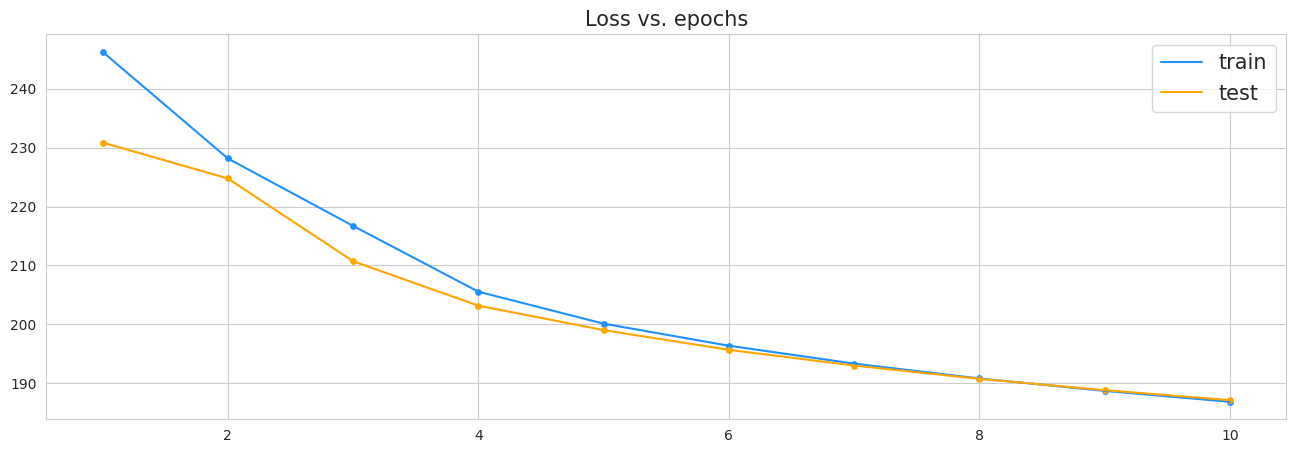

In [ ]:
epochs = []
train_losses = []
val_losses = []
# for epoch, epoch_stats in enumerate(training_stats, start=1):
#   epochs.append(epoch)
#   train_losses.append(epoch_stats['train_loss'])
#   val_losses.append(epoch_stats['val_loss'])
for file_name in [file_name for file_name in os.listdir(trained_gpt_path) if file_name.startswith('epoch_')]:
  epochs.append(extract_epoch_from_path(gdrive_path=file_name))
  train_losses.append(extract_loss_from_path(gdrive_path=file_name, loss_type='train_loss'))
  val_losses.append(extract_loss_from_path(gdrive_path=file_name, loss_type='test_loss'))


plt.figure(figsize=(16, 5))
plt.title('Loss vs. epochs', fontsize=15);
plt.plot(
  epochs,
  train_losses,
  color='dodgerblue',
  label='train'
)
plt.scatter(
  epochs,
  train_losses,
  color='dodgerblue',
  s=15
)

plt.plot(
  epochs,
  val_losses,
  color='orange',
  label='test'
)
plt.scatter(
  epochs,
  val_losses,
  color='orange',
  s=15
)
plt.legend(fontsize=15);

In [ ]:
def leave_topk_largest_logits(
  logits: torch.FloatTensor,
  k: int
) -> torch.FloatTensor:
  values, idx = torch.topk(logits, k)
  logits_only_topk = logits.clone()
  logits_only_topk[logits_only_topk < values[:, [-1]]] = float(-1e10)
  return logits_only_topk

def generate(
  model: nn.Module,
  tokenizer: GPT2TokenizerFast,
  context: str,
  context_max_length: int,
  max_new_tokens: int = 50,
  topk_largest: t.Optional[int] = None,
) -> str:
  input_tokens = text_to_token_ids(
    text=context,
    tokenizer=tokenizer,
  )
  BatchSize, SeqLen = input_tokens.shape

  model.eval()
  generated_token_ids: list[int] = []
  with torch.no_grad():
    for _ in tqdm(range(max_new_tokens)):
      output_logits = model(input_tokens) # (BatchSize, SeqLen, VocabSize)
      last_timestamp_logits = output_logits[:, -1, :] # (BatchSize, VocabSize)

      if topk_largest is not None:
        last_timestamp_logits = leave_topk_largest_logits(
          logits=last_timestamp_logits,
          k=topk_largest
        )

      next_token = torch.multinomial(
        input=F.softmax(last_timestamp_logits.squeeze(), dim=0),
        num_samples=1,
      ).item()
      generated_token_ids.append(next_token)

      input_tokens = torch.cat([input_tokens[0], torch.LongTensor([next_token])])[-context_max_length:].unsqueeze(0)

  return token_ids_to_text(
    token_ids=torch.LongTensor(generated_token_ids),
    tokenizer=tokenizer
  )



In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(pjoin(trained_gpt_path, 'tokenizer'))
tokenizer

GPT2TokenizerFast(name_or_path='/content/drive/MyDrive/GPT_from_scratch/tokenizer', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [ ]:
import json
model_params = json.load(open(pjoin(trained_gpt_path, 'model_parameters.json'), mode='r', encoding='utf-8'))

nontrained_model = GPT(
  num_heads=model_params['num_heads'],
  vocab_size=model_params['vocab_size'],
  embed_dim=model_params['input_emb_dim'],
  attention_dim=model_params['attention_dim'],
  num_blocks=model_params['num_blocks'],
  context_length=model_params['context_length'],
  dropout_rate=model_params['dropout_rate'],
  bias=model_params['bias'],
)
nontrained_model

GPT(
  (input_embedder): Embedding(50257, 250)
  (positional_embedder): Embedding(64, 250)
  (transformer_decoder_blocks): ModuleList(
    (0-9): 10 x TransformerDecoder(
      (multi_head_self_attention): MultiheadAttention(
        (heads): ModuleList(
          (0-9): 10 x SelfAttention(
            (Wq): Linear(in_features=250, out_features=25, bias=False)
            (Wk): Linear(in_features=250, out_features=25, bias=False)
            (Wv): Linear(in_features=250, out_features=25, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ff): FeedForward(
        (projection_up): Linear(in_features=250, out_features=1000, bias=True)
        (projection_down): Linear(in_features=1000, out_features=250, bias=True)
        (nonlinearity): GELU(approximate='none')
      )
      (layer_norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_no

In [ ]:
# nontrained model
context = "I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually"

generate(
  model=nontrained_model,
  tokenizer=tokenizer,
  context=context,
  context_max_length=model_params['context_length'],
  max_new_tokens=50,
  # topk_largest=15,
)

100%|██████████| 50/50 [00:02<00:00, 23.48it/s]


' movementsadeonz medicapacity scoreboard springs challenging claimingPARatorial placed Osakaigs magazinehtudo Confederheaders ccwithin radiationantine vinegar cakeslad 03 tentative TED textileringerd Dagger solemn hypnotempty174 Jord temperamentHOWoliath Eliasriminationstart250 lifes pledge polled� breaches'

In [ ]:
import json
model_params = json.load(open(pjoin(trained_gpt_path, 'model_parameters.json'), mode='r', encoding='utf-8'))

trained_model = GPT(
  num_heads=model_params['num_heads'],
  vocab_size=model_params['vocab_size'],
  embed_dim=model_params['input_emb_dim'],
  attention_dim=model_params['attention_dim'],
  num_blocks=model_params['num_blocks'],
  context_length=model_params['context_length'],
  dropout_rate=model_params['dropout_rate'],
  bias=model_params['bias'],
)
checkpoint_name = sorted(
  [file_name for file_name in os.listdir(trained_gpt_path) if file_name.startswith('epoch_')],
  key=lambda x: int(str(x).split("_")[1].lstrip('0')),
  reverse=False
)[-1]
print(f"checkpoint_name: {checkpoint_name}")

trained_model_weigths_path = pjoin(trained_gpt_path, checkpoint_name)
trained_model.load_state_dict(torch.load(trained_model_weigths_path, map_location=torch.device('cpu'))['model_state'])
trained_model

checkpoint_name: epoch_010_train_loss_186.878_test_loss_187.156


GPT(
  (input_embedder): Embedding(50257, 250)
  (positional_embedder): Embedding(64, 250)
  (transformer_decoder_blocks): ModuleList(
    (0-9): 10 x TransformerDecoder(
      (multi_head_self_attention): MultiheadAttention(
        (heads): ModuleList(
          (0-9): 10 x SelfAttention(
            (Wq): Linear(in_features=250, out_features=25, bias=False)
            (Wk): Linear(in_features=250, out_features=25, bias=False)
            (Wv): Linear(in_features=250, out_features=25, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ff): FeedForward(
        (projection_up): Linear(in_features=250, out_features=1000, bias=True)
        (projection_down): Linear(in_features=1000, out_features=250, bias=True)
        (nonlinearity): GELU(approximate='none')
      )
      (layer_norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_no

In [ ]:
# trained model
context = "I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually"

generate(
  model=trained_model,
  tokenizer=tokenizer,
  context=context,
  context_max_length=model_params['context_length'],
  max_new_tokens=50,
  # topk_largest=15,
)

100%|██████████| 50/50 [00:02<00:00, 21.41it/s]


' in his performances house system. th attendantunder are very short, much Frank Brooks. find directing films, brutally, A cityles of true years, thanks out. means then a veryTom of "2" existential like The class-c adventureru'

## bottom